The official PyMC documentation provides a good introduction to the PyMC package using regression problems as examples: https://www.pymc.io/projects/docs/en/v5.7.2/learn/core_notebooks/pymc_overview.html

This notebook will provide an example of using PyMC to solve a decision analysis problem.

Question:

The maintenance manager of a manufacturing plant has been having trouble with a machine. In the last ten months, the machine broke down five times and was repaired each time. Today, the manager had key components of the machine upgraded. The manager now expects the machine to break down in five to seven months. Each time the machine breaks down an expected cost of 100,000 will be incurred relating to repairs and loss of production during down-time. The
manager can purchase insurance for 250,000 annually which will cover all expenses related to the machine's break downs within that year. The manager knows that the time between machine breakdowns can be modeled by an exponential distribution. However, because the machine was recently upgraded, the manager only has a rough idea about the expected time until failure. An analyst elicits that the manager's subjective prior for the failure rate (in months) follows a gamma distribution with shape = 0.25 and rate = 1.5. The manager decides not to purchase the insurance. Four months later, the machine fails. The insurance is still available at the same rate. Should the manager purchase the insurance?

In [8]:
print(123456)

123456


In [9]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Define the Model

In [10]:
model = pm.Model()

with model:

    # Priors for unknown model parameters
    failurerate = pm.Gamma("failurerate", alpha=0.25, beta=1.5) #alpha=shape, beta = rate

    breakdowns = pm.Poisson("breakdowns",mu=failurerate*12)

    # observations
    observedfailure = pm.Exponential("observedfailure",lam= failurerate, observed=4)

    #deterministic utility
    cost = pm.Deterministic("cost", breakdowns*100000)

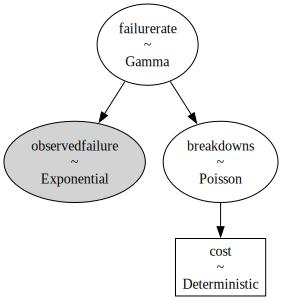

In [11]:
#this function visualizes your model graphically. Grey nodes denote observations
pm.model_to_graphviz(model)

# Sample from the model

In [12]:
with model:
    #draws is the number of samples per chain
    #tune is the number of "burn in" samples. We discard these first samples because we only want to keep samples from the steady state of the markov chain
    #chains is the number of markov chains to run
    trace = pm.sample(draws= 20000,tune=1000,chains=4, random_seed=0)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [failurerate]
>Metropolis: [breakdowns]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 31 seconds.
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
with model:
    #increasing target_accept will increase the accuracy of the sampler (reduce divergences), but slow down sampling
    trace = pm.sample(draws= 20000,tune=1000,chains=4, random_seed=0, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [failurerate]
>Metropolis: [breakdowns]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 27 seconds.


# Analyze Posterior

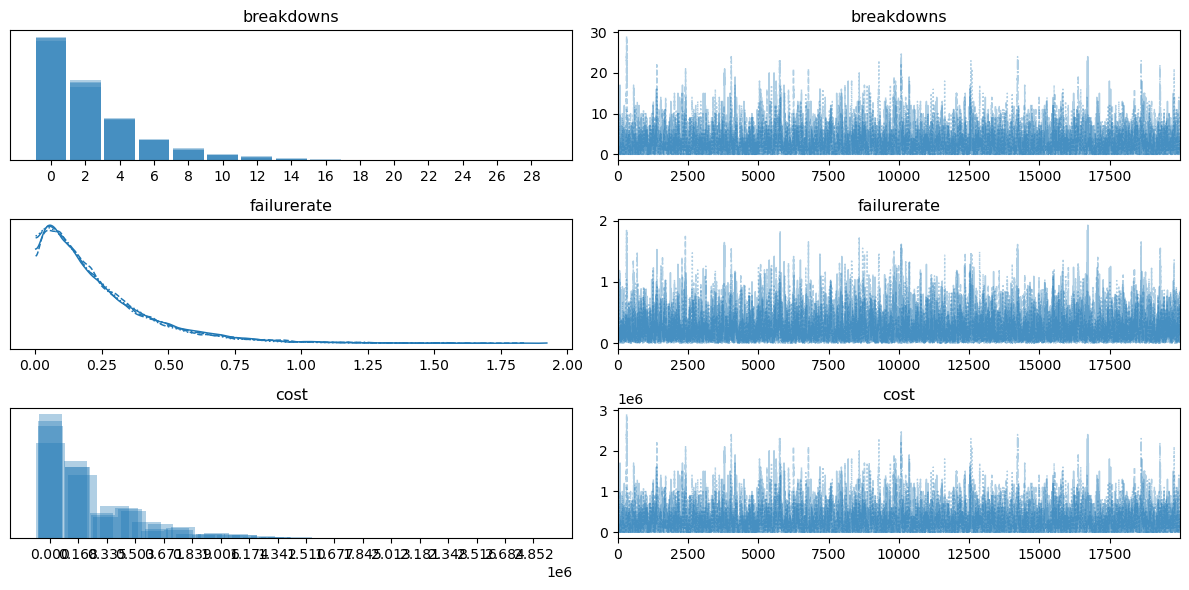

In [14]:
with model:
    az.plot_trace(trace)
    plt.tight_layout()
    plt.show()


Density plot on the left looks good as all 4 chains have very similar distributions.

Trace plot on the right looks good as there is no recognizable relationship between the order of the samples (x-axis) and the value of the samples (y-axis). We use this plot to "check" if our samples are independent from each other.

The gamma distribution is the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the exponential distribution so we actually didn't need to do MCMC sampling to get the posterior of the failurerate and could've computed it directly. Let's use the computed conjugate posterior as a sanity check for our MCMC samples.

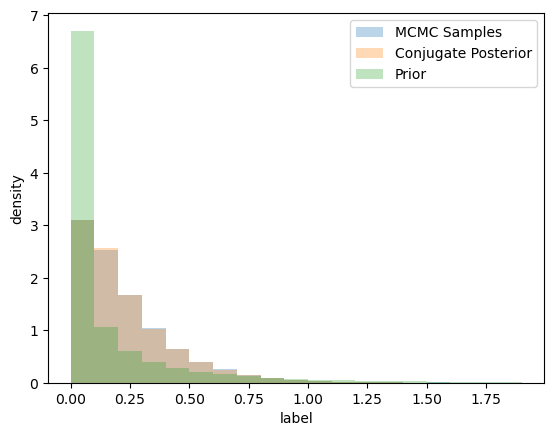

In [15]:
samples = trace['posterior']['failurerate'].to_numpy().flatten()
plt.hist(samples, density=True, alpha=0.3, bins=np.arange(0,2,0.1), label='MCMC Samples')
plt.hist(np.random.gamma(shape=1.25,scale=1/(4+3/2), size=100000), alpha=0.3, density=True, bins=np.arange(0,2,0.1), label = 'Conjugate Posterior') #scale=1/rate
plt.hist(np.random.gamma(shape=0.25,scale=2/3, size=100000), alpha=0.3, density=True, bins=np.arange(0,2,0.1), label='Prior')
plt.legend()
plt.xlabel('label')
plt.ylabel('density')
plt.show()

The MCMC and conjugate posterior distributions are almost identical! This shows that our MCMC model worked.

In [16]:
costsamples = trace['posterior']['cost'].to_numpy().flatten()
costsamples.mean()

280595.0

Our expected cost is greater than the cost of insurance so we should buy insurance.

# Piecewise Linear Utility Function

Suppose we have a piecewise linear utility function defined by the following points: (\$0, 1), (\$200 000, 0.5), (\$600 000, 0). With this utility function, should you buy insurance?

In [17]:
def U(x):
  return np.where(x<200000, 1-0.5/200000*x, 0.5 - 0.5/400000*(x-200000))

In [18]:
#Utility of no insurance
U(costsamples).mean()

0.4823359375

In [19]:
#Utility of insurance
U(250000)

array(0.4375)

We no longer want to buy insurance.